In [3]:
%load_ext autotime

In [4]:
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/enrique/')

time: 1.09 ms


In [5]:
import magellan as mg
mg.init_jvm()

DEBUG:Cloud:Log file (/Users/pradap/.picloud/cloud.log) opened


time: 5.4 s


## Workflow

### 1. Read input tables
### 2. Block tables to get candidate set  
### 3. Match tuple pairs in the candidate set

In [7]:
# read tables
A = mg.read_csv('DBLP_demo.csv', key='id')
B = mg.read_csv('ACM_demo.csv', key='id')

time: 17.5 ms


In [8]:
A.head(2)

,id,title,authors,venue,year
0,conf/sigmod/AbadiCCCCEGHMRSSTXYZ03,Aurora: A Data Stream Management System,"Nesime Tatbul, Daniel J. Abadi, C. Erwin, Anur...",SIGMOD Conference,2003
1,conf/sigmod/AcharyaAFZ95,Broadcast Disks: Data Management for Asymmetri...,"Michael J. Franklin, Stanley B. Zdonik, Swarup...",SIGMOD Conference,1995


time: 13.3 ms


In [9]:
B.head(2)

,id,title,authors,venue,year
0,335476,Of XML and databases (panel session): where's ...,"Jennifer Widom, Adam Bosworth, Bruce Lindsay, ...",International Conference on Management of Data,2000
1,672966,An Empirical Performance Study of the Ingres S...,"Sarabjot S. Anand, David A. Bell, John G. Hughes",Very Large Data Bases,1994


time: 11 ms


In [10]:
## Block tables to get candidate set

## Plan

## A, B -- AttrEquivalnce blocker [year]--------------------------| Candidate set

time: 836 µs


In [11]:
# Create attribute equivalence blocker
ab = mg.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C = ab.block_tables(A, B, 'year', 'year', 
                     l_output_attrs=['title', 'authors', 'venue'],
                     r_output_attrs=['title', 'authors', 'venue']
                    )

time: 47.9 ms


In [12]:
len(C)

14868

time: 2.12 ms


In [13]:
C.head(2)

,_id,ltable.id,rtable.id,ltable.title,ltable.authors,ltable.venue,rtable.title,rtable.authors,rtable.venue
0,0,conf/sigmod/AbadiCCCCEGHMRSSTXYZ03,872851,Aurora: A Data Stream Management System,"Nesime Tatbul, Daniel J. Abadi, C. Erwin, Anur...",SIGMOD Conference,QXtract: a building block for efficient inform...,"Eugene Agichtein, Luis Gravano",International Conference on Management of Data
1,1,conf/sigmod/AbadiCCCCEGHMRSSTXYZ03,872807,Aurora: A Data Stream Management System,"Nesime Tatbul, Daniel J. Abadi, C. Erwin, Anur...",SIGMOD Conference,Formal semantics and analysis of object queries,G. M. Bierman,International Conference on Management of Data


time: 14.8 ms


In [14]:
# debug blocker
# check whether the current blocking method has dropped a lot of potential matches

dbg = mg.debug_blocker(A, B, C, output_size=50)

0%                          100%
[##############################] | ETA[sec]: 0.000 

time: 3.56 s



Total time elapsed: 3.233 sec


In [15]:
# view the result from debug blocker
mg.view(dbg)

time: 53.8 s


In [ ]:
# Revised blocking plan

# A, B -- AttrEquivalnce blocker [year] --------------------|
#                                                           |---> candidate set
# A, B -- Overlap blocker [title]---------------------------|

In [16]:
ob = mg.OverlapBlocker()
D = ob.block_tables(A, B, 'title', 'title', rem_stop_words=False, 
                    word_level=True, overlap_size=1)

0%                          100%
[##############################] | ETA[sec]: 0.000 

time: 1.67 s



Total time elapsed: 1.232 sec


In [17]:
# Combine the candidate sets from attribute equivalence and overlap blocker
E = mg.combine_block_outputs_via_union([C, D])

time: 291 ms


In [18]:
# Check the length
len(E)

64862

time: 2.17 ms


In [19]:
# debug blocker
# check again with the updated blocking pipleline
dbg = mg.debug_blocker(A, B, E, output_size=50)

0%                          100%
[##############################] | ETA[sec]: 0.000 

time: 3.36 s



Total time elapsed: 2.926 sec


In [20]:
mg.view(dbg)

time: 44.3 s


In [ ]:
# Match tuple pairs in candidate set.

# Change 

# Use supervised learning based matcher

# Plan

# 1. Sample candidate set --> S
# 2. Label S --> G
# 3. Split G into development set I, and evaluation set J
# 4. Select best learning-based matcher Y, using I
# 5. Evaluate Y using J

In [21]:
# Sample the candidate set
S = mg.sample_table(C, 450)

time: 7.67 ms


In [22]:
# Label S
G = mg.label_table(S, 'gold')

time: 16.6 s


In [23]:
# For the demo, use pre-labeled data
G = mg.read_csv('dblp_acm_demo_labels.csv', ltable=A, rtable=B)
len(G)

415

time: 8.48 ms


In [24]:
# Split G into development (I) and evaluation (J)
IJ = mg.train_test_split(G, train_proportion=0.7)
I = IJ['train']
J = IJ['test']

time: 4.8 ms


In [25]:
# check the number of tuples in I and J
(len(I), len(J))

(290, 125)

time: 2.25 ms


In [ ]:
# Selecting the best learning-based matcher using I

# Plan 

# 1. Create a set of ML-matchers
# 2. Generate features --> feature_table
# 3. Extract feature vectors using I and feature_table
# 4. Select best learning-based matcher using CV
# 5. Debug the selected matcher (and repeat the above steps)

In [26]:
# Create a set of ML-matchers
dt = mg.DTMatcher(name='DecisionTree', random_state=0)
svm = mg.SVMMatcher()
rf = mg.RFMatcher(name='RF', random_state=1)
nb = mg.NBMatcher(name='NB')
lg = mg.LogRegMatcher(name='LogReg')
ln = mg.LinRegMatcher(name='LinReg')

time: 4.19 ms


In [27]:
# Generate features
feat_table = mg.get_features_for_matching(A, B)

time: 15.9 ms


In [28]:
feat_table

,feature_name,left_attribute,right_attribute,left_attr_tokenizer,right_attr_tokenizer,simfunction,function,function_source
0,title_title_jac_qgm_3_qgm_3,title,title,qgm_3,qgm_3,jaccard,<function title_title_jac_qgm_3_qgm_3 at 0x11f...,from magellan.feature.simfunctions import *\nf...
1,title_title_cos_dlm_dc0_dlm_dc0,title,title,dlm_dc0,dlm_dc0,cosine,<function title_title_cos_dlm_dc0_dlm_dc0 at 0...,from magellan.feature.simfunctions import *\nf...
2,title_title_mel,title,title,None,None,monge_elkan,<function title_title_mel at 0x11fef91b8>,from magellan.feature.simfunctions import *\nf...
3,title_title_lev,title,title,None,None,lev,<function title_title_lev at 0x11fef9230>,from magellan.feature.simfunctions import *\nf...
4,authors_authors_jac_qgm_3_qgm_3,authors,authors,qgm_3,qgm_3,jaccard,<function authors_authors_jac_qgm_3_qgm_3 at 0...,from magellan.feature.simfunctions import *\nf...
5,authors_authors_cos_dlm_dc0_dlm_dc0,authors,authors,dlm_dc0,dlm_dc0,cosine,<function authors_authors_cos_dlm_dc0_dlm_dc0 ...,from magellan.feature.simfunctions import *\nf...
6,authors_authors_mel,authors,authors,None,None,monge_elkan,<function authors_authors_mel at 0x11fef9398>,from magellan.feature.simfunctions import *\nf...
7,authors_authors_lev,authors,authors,None,None,lev,<function authors_authors_lev at 0x11fef9410>,from magellan.feature.simfunctions import *\nf...
8,year_year_exm,year,year,None,None,exact_match,<function year_year_exm at 0x11fef9488>,from magellan.feature.simfunctions import *\nf...
9,year_year_anm,year,year,None,None,abs_norm,<function year_year_anm at 0x11fef9500>,from magellan.feature.simfunctions import *\nf...


time: 23.8 ms


In [29]:
# Select authors + year related features
feat_subset_iter1 = feat_table[6:11]

time: 1.29 ms


In [30]:
# Get feature vectors
K = mg.extract_feature_vecs(I, feature_table=feat_subset_iter1, attrs_after='gold')

time: 440 ms


In [31]:
K.head(15)

,_id,ltable.id,rtable.id,authors_authors_mel,authors_authors_lev,year_year_exm,year_year_anm,year_year_lev,gold
0,0,journals/tods/Galindo-LegariaR97,244812,0.962162,0.875000,1,1.000000,0.666667,1
1,1,journals/sigmod/Franklin98b,765559,0.578947,0.263158,0,0.999499,0.500000,0
2,2,conf/vldb/Mina98,671162,1.000000,1.000000,1,1.000000,0.666667,1
3,3,journals/sigmod/Abiteboul99,671497,1.000000,0.062500,1,1.000000,0.666667,0
4,4,journals/vldb/MylopoulosCPST96,765853,0.445977,0.411111,1,1.000000,0.666667,1
5,5,conf/sigmod/HacigumusILM02,564717,0.530612,0.366667,1,1.000000,0.666667,1
6,6,journals/tods/FernandezKSMT02,582413,0.437333,0.291139,1,1.000000,0.666667,1
7,7,conf/sigmod/SchleimerWA03,671505,0.297143,0.372881,0,0.998003,0.000000,0
8,8,conf/vldb/VieiraM03,640997,0.200000,0.227273,1,1.000000,0.666667,0
9,9,conf/vldb/LakshmananSS99,671511,0.526667,0.433333,1,1.000000,0.666667,1


time: 20.7 ms


In [32]:
# impute K
K.fillna(0, inplace=True)

time: 2.02 ms


In [33]:
K.head(15)

,_id,ltable.id,rtable.id,authors_authors_mel,authors_authors_lev,year_year_exm,year_year_anm,year_year_lev,gold
0,0,journals/tods/Galindo-LegariaR97,244812,0.962162,0.875000,1,1.000000,0.666667,1
1,1,journals/sigmod/Franklin98b,765559,0.578947,0.263158,0,0.999499,0.500000,0
2,2,conf/vldb/Mina98,671162,1.000000,1.000000,1,1.000000,0.666667,1
3,3,journals/sigmod/Abiteboul99,671497,1.000000,0.062500,1,1.000000,0.666667,0
4,4,journals/vldb/MylopoulosCPST96,765853,0.445977,0.411111,1,1.000000,0.666667,1
5,5,conf/sigmod/HacigumusILM02,564717,0.530612,0.366667,1,1.000000,0.666667,1
6,6,journals/tods/FernandezKSMT02,582413,0.437333,0.291139,1,1.000000,0.666667,1
7,7,conf/sigmod/SchleimerWA03,671505,0.297143,0.372881,0,0.998003,0.000000,0
8,8,conf/vldb/VieiraM03,640997,0.200000,0.227273,1,1.000000,0.666667,0
9,9,conf/vldb/LakshmananSS99,671511,0.526667,0.433333,1,1.000000,0.666667,1


time: 24.6 ms


In [34]:
# select the best ML matcher using CV
result = mg.select_matcher([dt, rf, svm, nb, lg, ln], table=K, 
        exclude_attrs=['_id', 'ltable.id', 'rtable.id', 'gold'],
        target_attr='gold', metric='f1', random_state=2) 

time: 101 ms


In [35]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<magellan.matcher.dtmatcher.DTMatcher object a...,5,0.916667,0.886076,0.949153,0.953846,0.957746,0.932698
1,RF,<magellan.matcher.rfmatcher.RFMatcher object a...,5,0.880000,0.900000,0.915254,0.953846,0.986301,0.927080
2,SVM_69800617339443128441,<magellan.matcher.svmmatcher.SVMMatcher object...,5,0.745763,0.919540,0.892308,0.955224,0.875000,0.877567
3,NB,<magellan.matcher.nbmatcher.NBMatcher object a...,5,0.745763,0.952381,0.906250,0.941176,0.875000,0.884114
4,LogReg,<magellan.matcher.logregmatcher.LogRegMatcher ...,5,0.836364,0.952381,0.920635,0.941176,0.960000,0.922111
5,LinReg,<magellan.matcher.linregmatcher.LinRegMatcher ...,5,0.779661,0.941176,0.906250,0.941176,0.923077,0.898268


time: 16 ms


In [36]:
# Debug decision tree

# Split feature vectors to train and test
UV = mg.train_test_split(K, train_proportion=0.5, random_state=3)
U = UV['train']
V = UV['test']

time: 4.93 ms


In [37]:
mg.vis_debug_dt(dt, U, V, 
        exclude_attrs=['_id', 'ltable.id', 'rtable.id', 'gold'],
        target_attr='gold')

time: 2min 24s


In [38]:
mg.visualize_tree(dt, K.columns, exclude_attrs=['_id', 'ltable.id', 'rtable.id', 'gold'])

Execute the following command in IPython command prompt:

from IPython.display import Image
Image(filename='dt_.png') 
time: 522 ms


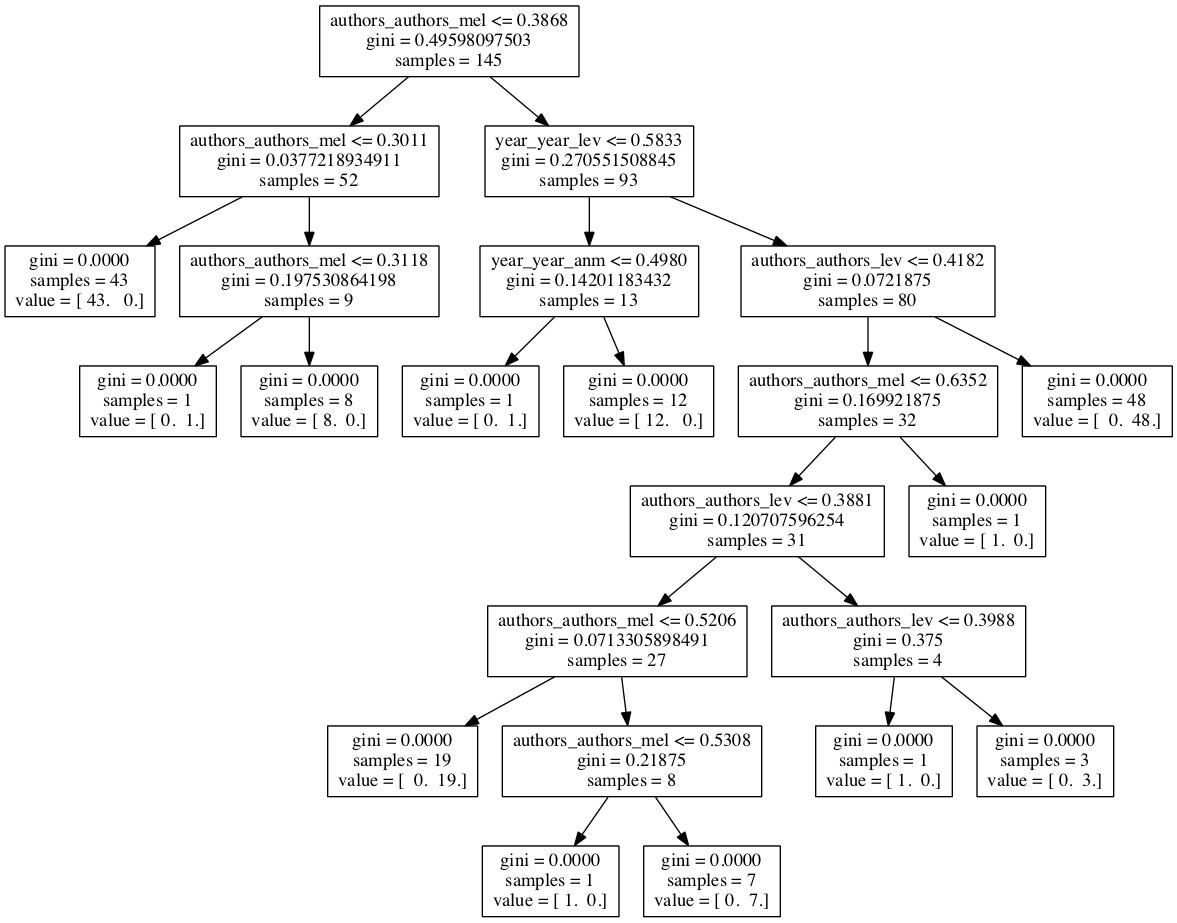

time: 21.4 ms


In [39]:
from IPython.display import Image
Image(filename='dt_.png') 

In [40]:
# Select all features
feat_subset_iter2 = feat_table

time: 1.07 ms


In [41]:
# Get new set of features
K = mg.extract_feature_vecs(I, feature_table=feat_subset_iter2, attrs_after='gold')
# impute K
K.fillna(0, inplace=True)

time: 621 ms


In [42]:
# Apply cross validation to find if there is a better matcher
result = mg.select_matcher([dt, rf, svm, nb, lg, ln], table=K, 
        exclude_attrs=['_id', 'ltable.id', 'rtable.id', 'gold'],
        target_attr='gold', metric='f1') 

time: 91.3 ms


In [43]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<magellan.matcher.dtmatcher.DTMatcher object a...,5,0.968750,0.985075,0.969697,1.000000,0.985507,0.981806
1,RF,<magellan.matcher.rfmatcher.RFMatcher object a...,5,1.000000,0.960000,0.952381,0.956522,0.986667,0.971114
2,SVM_69800617339443128441,<magellan.matcher.svmmatcher.SVMMatcher object...,5,1.000000,0.985075,0.983607,1.000000,0.986667,0.991070
3,NB,<magellan.matcher.nbmatcher.NBMatcher object a...,5,0.985075,0.983051,0.965517,0.969697,0.986301,0.977928
4,LogReg,<magellan.matcher.logregmatcher.LogRegMatcher ...,5,1.000000,1.000000,0.969697,0.985507,0.966667,0.984374
5,LinReg,<magellan.matcher.linregmatcher.LinRegMatcher ...,5,1.000000,0.967742,1.000000,0.985915,0.985915,0.987915


time: 16 ms


In [44]:
# Validate Y using J
# Steps
# 1. Extract feature vectors (using feat_subset_iter2) -- > M
# 2. Train DT using K (feature vectors generated using I)
# 3. Predict M using DT
# 4. Evaluate the result

time: 1.46 ms


In [45]:
# Extract feature vectors
M = mg.extract_feature_vecs(J, feature_table=feat_subset_iter2, attrs_after='gold')

time: 282 ms


In [46]:
# Extract feature vectors
M = mg.extract_feature_vecs(J, feature_table=feat_subset_iter2, attrs_after='gold')
# Impute missing values
M.fillna(0, inplace=True)

time: 271 ms


In [47]:
# Train using feature vectors from I 
dt.fit(table=K, 
       exclude_attrs=['_id', 'ltable.id', 'rtable.id', 'gold'], 
       target_attr='gold')
# Predict M 
N = dt.predict(table=M, exclude_attrs=['_id', 'ltable.id', 'rtable.id', 'gold'], 
              append=True, target_attr='predicted', inplace=False)

time: 27.6 ms


In [48]:
# Evaluate the result
eval_result = mg.eval_matches(N, 'gold', 'predicted')
mg.print_eval_summary(eval_result)


Precision : 100.0% (68/68)
Recall : 98.55% (68/69)
F1 : 99.27%
False positives : 0 (out of 68 positive predictions)
False negatives : 1 (out of 57 negative predictions)
time: 15 ms
